# Homework w08d04 - Pymc

We are going to use the starcraft dataset from the lab.

#### Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import pymc3 as pm

In [2]:
star = pd.read_csv('assets/datasets/skillcraft1_dataset.csv')
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


#### In the lab, we compared the APM for different age groups and found by Monte Carlo simulation differences and similarities among the statistical properties of the groups.

In [3]:
apm19 = star[star.Age == '19']["APM"].values
apm26 = star[star.Age == '26']["APM"].values

#### In the lab, we went through the following steps:

### Set up the bayesian model and priors on means

In [4]:
mean_prior_mean = star["APM"].mean()
mean_prior_std = star["APM"].std()

In [5]:
# model specifications in PyMC3 are wrapped in a with-statement
with pm.Model() as model:
    group19_mean = pm.Normal('APM_19yo_mean', mean_prior_mean, sd=mean_prior_std)
    group26_mean = pm.Normal('APM_26yo_mean', mean_prior_mean, sd=mean_prior_std)

### Priors on standard deviations

In [6]:
std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    group19_std = pm.Uniform('APM_19yo_std', lower=std_prior_lower, upper=std_prior_upper)
    group26_std = pm.Uniform('APM_26yo_std', lower=std_prior_lower, upper=std_prior_upper)

Applied interval-transform to APM_19yo_std and added transformed APM_19yo_std_interval_ to model.
Applied interval-transform to APM_26yo_std and added transformed APM_26yo_std_interval_ to model.


### Set up the APM distributions for groups

In [7]:
with model:
    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)

### Defining additional metrics

In [8]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group19_mean - group26_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group19_std - group26_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((group19_std**2 + group26_std**2) / 2))

### Fitting the model with MCMC

In [9]:
with model:
    trace = pm.sample(25000, njobs=4)

Assigned NUTS to APM_19yo_mean
Assigned NUTS to APM_26yo_mean
Assigned NUTS to APM_19yo_std_interval_
Assigned NUTS to APM_26yo_std_interval_
100%|██████████| 25000/25000 [00:58<00:00, 430.32it/s]


### Plotting posteriors and result distributions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x121484710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1223d8810>], dtype=object)

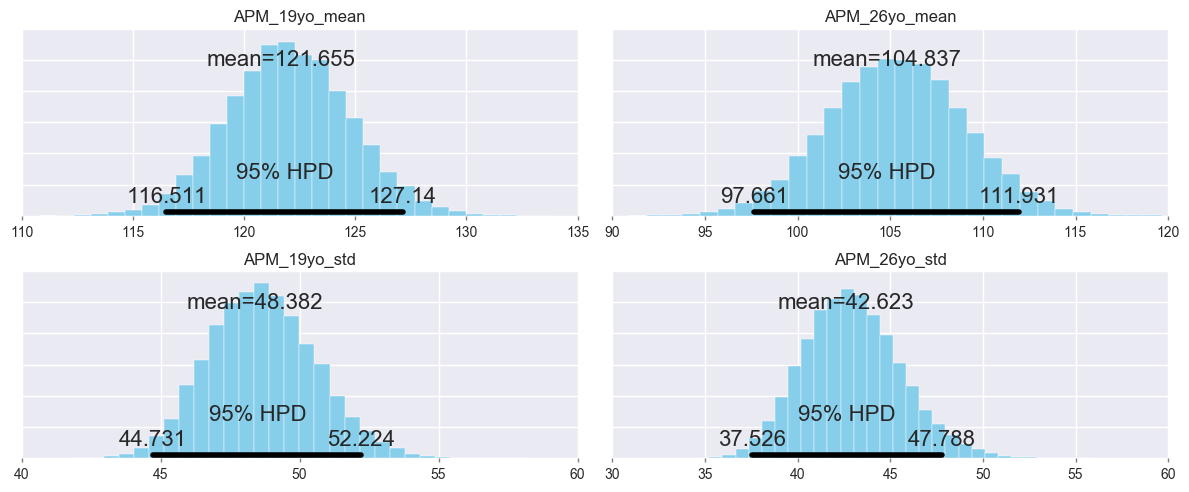

In [10]:
#[3000:]
pm.plot_posterior(trace,
                  varnames=['APM_19yo_mean', 'APM_26yo_mean', 'APM_19yo_std', 'APM_26yo_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123ff8710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x123f47f10>], dtype=object)

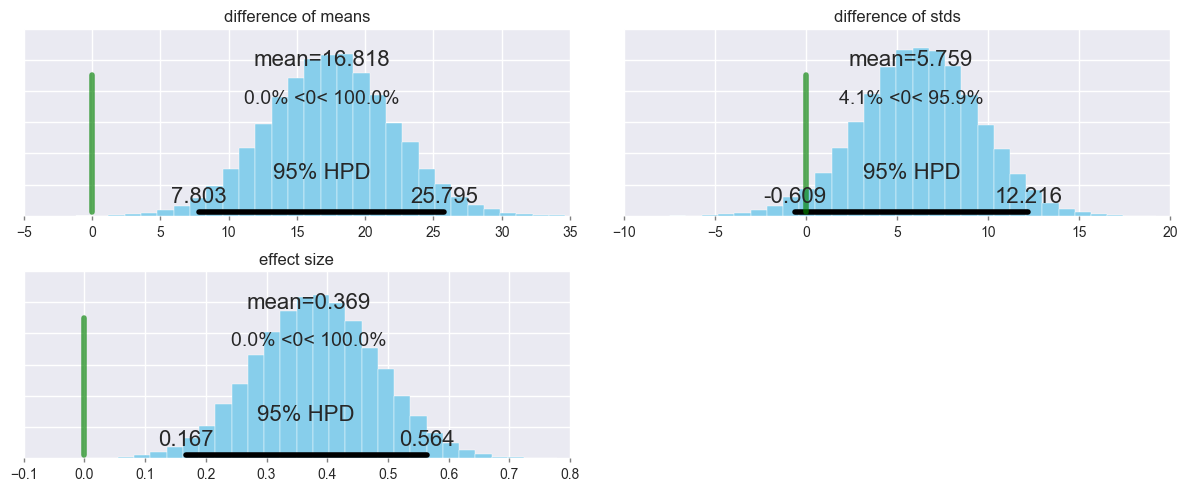

In [11]:
#[3000:]
pm.plot_posterior(trace,
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [12]:
#[3000:]
pm.summary(trace,
           varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  16.818           4.588            0.014            [7.803, 25.795]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  7.819          13.727         16.823         19.888         25.838


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.759            3.263            0.009            [-0.609, 12.216]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.891         3.609          5.796          7.959          12.028


effect size:

  Mean             SD               MC Error         95% HP

## Perform your own comparison with pymc3

Following the code above, we are going to repeat the same analysis with different groups and values. 

1. Choose the two groups which play 10 and 28 HoursPerWeek. We want to compare the ComplexAbilitiesUsed of these two groups. 
1. Set up priors for the mean (normally distributed) and standard deviation (uniformly distributed between $10^{-6}$ and $10^{-4}$) of ComplexAbilitiesUsed of each group and the corresponding likelihood function. 
1. Set up distributions for the differences of the means and standard deviations of each group.
1. Run the Monte Carlo to obtain the posterior distribution of mean and standard deviation and their differences for each group. 
1.  Plot the posterior probability distributions for the mean, the standard deviation and their differences.
1. Do the means and standard deviations of the two groups differ significantly?